In [ ]:
Github: https://github.com/lassancetecnologia/tcc_bimaster_2019.4

#1.Importação de Bibliotecas

In [ ]:
import os
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.cluster import DBSCAN
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as ss

!pip install python-docx
from docx import Document
from docx.shared import Inches

import sklearn.preprocessing
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report,accuracy_score

#2.Conexão ao Google Drive

In [ ]:
# MONTAR O DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3.Função para tratamento de dados e geração de DataFrame para estudos

In [ ]:
def tratamento_dados(path, data_inicial, data_final, hora_inicial, hora_final, func_maq):
  # Argumentos
  # path: STRING - caminho da pasta para os arquivos csv das variáveis
  # data_inicial: STRING 'AAAA-MM-DD'
  # data_final: STRING 'AAAA-MM-DD'
  # hora_inicial: INT
  # hora_final: INT
  # func_maq: 0/1 usar ou não somente os dados da máquina ligada


  lista_arquivos = os.listdir(path=path)

  df = pd.DataFrame()
  df_aux = pd.DataFrame()
  count = -1

  # Varredura da pasta pelos arquivps csv das variáveis
  for variavel in lista_arquivos: 


    if variavel[-4:] == '.csv':
      count = count + 1 
      
      # 1. Coleta de csv
      df_aux = pd.read_csv(variavel)

      # Tratamento do dataframe
      df_aux = df_aux.iloc[::-1]
      df_aux = df_aux.reset_index(drop=True)
      df_aux = df_aux.drop(columns=['id','origin'])
      if 'unit' in df_aux: 
        df_aux = df_aux.drop(columns=['unit'])
      if 'metadata' in df_aux: 
        df_aux = df_aux.drop(columns=['metadata'])  
      df_aux = df_aux.rename(columns={'value': variavel[:-4]})
      df_aux = df_aux.drop(columns=['variable'])

      df_aux['time'] = pd.to_datetime(df_aux['time'])

      if count == 0: # Primeira rodada
        df = df_aux
        
      if count > 0: # Rodadas seguintes, necessário juntar dataframes
        df = pd.merge_asof(df, df_aux, on='time', direction="nearest", tolerance=pd.Timedelta("1 min"))
        
  # Mapeamento de atributos categóricos
  df['controle_on_off_ihm'] = df['controle_on_off_ihm'].map({'Ligado': 1, 'Desligado': 0})
  df['modo_ihm'] = df['modo_ihm'].map({'Frio': -1, 'Ventilador': 0, 'Aquecimento': 1})

  #df['controle_on_off_ihm'] = df['controle_on_off_ihm'].astype(int)
  #df['modo_ihm'] = df['modo_ihm'].astype(int)


  # Correção de fuso horário 
  array_hora_utc = df['time']
  df['time'] = pd.DatetimeIndex(array_hora_utc).tz_convert('Etc/GMT+3')

  # Exclusão de dados fora das datas
  df = df[df['time'] >= data_inicial + ' 00:00:00']
  df = df[df['time'] < data_final + ' 00:00:00']

  df = df.reset_index()
  df = df.drop(columns=['index'],axis=1)
  if len(df) == 0:
    return

  # Exclusão de dados fora dos horários determinados
  for i in range(len(df['time'])):
    hora = str(i)
    if len(hora) == 1:
      hora = '0' + hora
    
    if df['time'][i].hour < hora_inicial or df['time'][i].hour >= hora_final:
      df = df.drop([i])

  df = df.reset_index() # atualizando os indexes
  df = df.drop(columns=['index'],axis=1)

  # Exclusão de dados com máquina desligada
  if func_maq == 1:
    for i in range(len(df['time'])):
      if df['controle_on_off_ihm'][i] == 0:
        df = df.drop([i])


  # Missing values
  a = df[df['controle_on_off_ihm'].isna() == True].index.to_list()
  df = df.drop(a)
  df = df.reset_index() # atualizando os indexes
  df = df.drop(columns=['index'])

  # Novos dados
  df['erro_temp'] = df['temp_amb_retorno'] - df['setpoint_temp_ihm']
  if 'corrente_compressor' in df.columns:
    df['potencia'] = df['corrente_compressor'] * 220

  array_hora = pd.Series()
  array_hora = df['time'].astype(str)
  for index, value in array_hora.items():
    array_hora[index] = value[11:13]

  df['hora'] = array_hora

  return df

#4.Função para estudos estatísticos e geração de DataFrame com resultados

In [ ]:
def estudos_estatisticos(df,tol_temp_sp,lim_temp_sup,lim_temp_inf):
  # Argumentos:
  # df: dataframe da máquina com dados tratados
  # tol_temp_sp: float - tolerância aceitável acima e abaixo do setpoint


  data = pd.DataFrame()


  # Erro
  erro_medio = df['erro_temp'].mean()
  erro_max = df['erro_temp'].max()
  erro_min = df['erro_temp'].min()


  # Comparação com setpoint
  dados_coletados = len(df)
  acima_sp = len(df[df['erro_temp'] > tol_temp_sp])
  abaixo_sp = len(df[df['erro_temp'] < tol_temp_sp*(-1)])
  horas_acima_sp = acima_sp / 4
  horas_abaixo_sp = abaixo_sp / 4
  horas_dentro_sp = (dados_coletados - acima_sp - abaixo_sp) / 4
  horas_fora_sp = (acima_sp + abaixo_sp) / 4
  perc_acima_sp = acima_sp / dados_coletados
  perc_abaixo_sp = abaixo_sp / dados_coletados
  efic_maq_sp = 1 - perc_acima_sp - perc_abaixo_sp


  # Comparação com limites desejáveis lim_temp_sup lim_temp_inf
  acima_lim_temp = len(df[df['erro_temp'] > lim_temp_sup])
  abaixo_lim_temp = len(df[df['erro_temp'] < lim_temp_inf])
  horas_acima_lim_temp = acima_lim_temp / 4
  horas_abaixo_lim_temp = abaixo_lim_temp / 4
  horas_dentro_lim_temp = (dados_coletados - acima_lim_temp - abaixo_lim_temp) / 4
  horas_fora_lim_temp = (acima_lim_temp + abaixo_lim_temp) / 4
  perc_acima_lim_temp = acima_lim_temp / dados_coletados
  perc_abaixo_lim_temp = abaixo_lim_temp / dados_coletados
  efic_maq_lim_temp = 1 - perc_acima_lim_temp - perc_abaixo_lim_temp
  

  # Erro médio por hora
  df_aux = df[['hora','erro_temp']]
  df_aux = df_aux.groupby(['hora'],as_index=False).mean()
  df_aux = df_aux.sort_values(by='erro_temp',ascending=False)
  top_hrs_acima_sp = df_aux['hora'][:3].to_list()
  top_hrs_abaixo_sp = df_aux['hora'][-3:].to_list()


  # Códigos de erro da máquina
  qt_erros = len(df[df['codigo_falha'] != 0])
  horas_erros = qt_erros / 4
  tipos_erros = df[df['codigo_falha'] != 0]['codigo_falha'].value_counts().index.to_list()

  df_erro = df[df['codigo_falha'] != 0]['codigo_falha'].value_counts().to_frame()
  df_erro = df_erro.rename(columns={"codigo_falha": "quantidade"})
  df_erro['codigo_falha'] = df_erro.index
  df_erro = df_erro.reset_index(drop=True)
  df_erro = df_erro.sort_values(by='quantidade',ascending=False)
  top_erro = df_erro['codigo_falha'][0]
  

  
  dados_gerais = [erro_medio,erro_max,erro_min,dados_coletados,acima_sp,abaixo_sp,
                  horas_acima_sp,horas_abaixo_sp,horas_dentro_sp,horas_fora_sp,perc_acima_sp,perc_abaixo_sp,efic_maq_sp,
                  acima_lim_temp,abaixo_lim_temp,horas_acima_lim_temp,
                  horas_abaixo_lim_temp,horas_dentro_lim_temp,horas_fora_lim_temp,
                  perc_acima_lim_temp,perc_abaixo_lim_temp,efic_maq_lim_temp,
                  top_hrs_acima_sp,top_hrs_abaixo_sp,
                  qt_erros,horas_erros,tipos_erros,top_erro
            ]

  colunas = ['erro_medio','erro_max','erro_min','dados_coletados','acima_sp','abaixo_sp',
             'horas_acima_sp','horas_abaixo_sp','horas_dentro_sp','horas_fora_sp','perc_acima_sp','perc_abaixo_sp','efic_maq_sp',
             'acima_lim_temp','abaixo_lim_temp','horas_acima_lim_temp',
             'horas_abaixo_lim_temp','horas_dentro_lim_temp','horas_fora_lim_temp',
             'perc_acima_lim_temp','perc_abaixo_lim_temp','efic_maq_lim_temp',
             'top_hrs_acima_sp','top_hrs_abaixo_sp',
             'qt_erros','horas_erros','tipos_erros','top_erro'
            ]

  df_geral = pd.DataFrame(data = np.array([dados_gerais]), columns = colunas)


  df_geral = df_geral.transpose()
  df_geral = df_geral.rename(columns={0: str(df['time'][0])[:7]})

  return df_geral

  # lembrar de tratar caso em que não haja dados

#5.Função de plotagem de variáveis para estudo e análise visual

In [ ]:
# Plotagem dos dados para estudo geral
def estudo_imagens(path,df):

  os.chdir(path)


  for var in df.columns[1:]:
    plt.close()
    plt.figure(figsize=(6,3))
    plt.scatter(df['time'],df[var])
    plt.title(var+'_scatter')
    plt.savefig(fname=var+'_scatter', dpi=150, facecolor='w', edgecolor='w', orientation='landscape', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)

    plt.close()
    plt.figure(figsize=(6,3))
    plt.hist(df[var])
    plt.title(var+'_hist')
    plt.savefig(fname=var+'_hist', dpi=150, facecolor='w', edgecolor='w', orientation='landscape', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)
    plt.close()


#6.Funções de avaliação de z-core e z-score modificado

In [ ]:
# Função para Z-score modificado

def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)

    return mod_zscore, mad

In [ ]:
# Funções para plotagem de gráficos de z-score

def plot_anomaly_zscore(score_data, threshold, variavel, pos_neg):
  # Mask to plot values above and below threshold in different colors

  score_data = score_data.copy().sort_values(ascending=False).values
  ranks = np.linspace(1, len(score_data), len(score_data))
  if pos_neg == 'pos':
    mask_outlier = (score_data > threshold)
  else:
    mask_outlier = (score_data < threshold)

  plt.figure(dpi=100)
  plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK')
  plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
  plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
  plt.legend(loc = 'lower left')
  plt.title('Z-score vs. ' + variavel, fontweight='bold')
  plt.xlabel(variavel)
  plt.ylabel('Z-score')
  #plt.show()
 


def plot_anomaly_mod_zscore(score_data, threshold, variavel, pos_neg):

  score_data = score_data.copy().sort_values(ascending=False).values
  ranks = np.linspace(1, len(score_data), len(score_data))
  if pos_neg == 'pos':
    mask_outliers = (score_data > threshold)
  else:
    mask_outliers = (score_data < threshold)

  plt.figure(dpi=150)
  plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
  plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
  plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
  plt.legend(loc = 'upper right')
  plt.title('Modified z-score vs. ' + variavel, fontweight='bold')
  plt.xticks(np.arange(0, 21, step=2.0))
  plt.xlabel(variavel)
  plt.ylabel('Modified z-score')
  #plt.show()

In [ ]:
def estudo_estatistico_anomalias(path, df, variavel, threshold_pos, threshold_neg):
  
  if variavel == 'time':
    df_stats_anomalies = pd.DataFrame()
    return df_stats_anomalies


  os.chdir(path)

  df_stats = pd.DataFrame()
  df_stats['time'] = df['time'][df[variavel] != 0]
  df_stats['valor'] = df[variavel][df[variavel] != 0]
  #print(df[df[variavel] != 0])

  # Cálculo de z-core e z-score modificado
  zscore_rate = ss.zscore(df_stats['valor'], ddof=0)
  df_stats['zscore'] = zscore_rate

  mod_zscore_rate, mad_rate = modified_zscore(df_stats['valor'])
  df_stats['mod_zscore'] = mod_zscore_rate


  # Z-core positivo
  plt.close()
  plot_name = variavel + '_zc_' + str(threshold_pos) + '.png'
  plot_anomaly_zscore(df_stats['zscore'], threshold_pos,variavel,'pos')
  if df_stats['zscore'].max() >= threshold_pos:
    plt.savefig(fname=plot_name, dpi=100, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)

  # Z-core negativo
  plt.close()
  plot_name = variavel + '_zc_' + str(threshold_neg) + '.png'
  plot_anomaly_zscore(df_stats['zscore'], threshold_neg,variavel,'neg')
  if df_stats['zscore'].min() <= threshold_neg:
    plt.savefig(fname=plot_name, dpi=100, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)

  # Z-core modificado positivo
  plt.close()
  plot_name = variavel + '_zc_mod_' + str(threshold_pos) + '.png'
  plot_anomaly_mod_zscore(df_stats['mod_zscore'], threshold_pos,variavel,'pos')
  if df_stats['mod_zscore'].max() >= threshold_pos:
    plt.savefig(fname=plot_name, dpi=100, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)

  # Z-core modificado negativo
  plt.close()
  plot_name = variavel + '_zc_mod_' + str(threshold_neg) + '.png'
  plot_anomaly_mod_zscore(df_stats['mod_zscore'], threshold_neg,variavel,'neg')
  if df_stats['mod_zscore'].min() <= threshold_neg:
    plt.savefig(fname=plot_name, dpi=100, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None, metadata=None)
  plt.close()


  df_stats['variavel'] = variavel   # inserção do nome da grandeza/variavel


  return df_stats

#X.Execução de funções

##X.1 Coleta e tratamento inicial de dados

In [ ]:
maquina_estudo = 'Inverter' # Inverter / Compressor 1 / Compressor 3

workdir_path = '/content/drive/My Drive/2. Greenole/9. Análises/00. Trabalho BI Master/1. Coleta de dados/HVAC-BK/' + maquina_estudo
os.chdir(workdir_path)

data_inicial = '2021-05-01'
data_final = '2021-08-01'
hora_inicial = 0
hora_final = 24
func_maq = 1              # func_maq = 1 --> considera somente registros com a máquina ligada 
tol_temp_sp = 2           # tolerância aceitável acima e abaixo do setpoint
lim_temp_sup = 26         # maior valor de temperatura ambiente aceitável
lim_temp_inf = 22         # menor valor de temperatura ambiente aceitável



df = tratamento_dados(workdir_path,data_inicial,data_final,hora_inicial,hora_final,func_maq)
df_geral = estudos_estatisticos(df,tol_temp_sp,lim_temp_sup,lim_temp_inf)



# Gera e salva imagens tipo historico e scatter das variáveis para análise visual

path = '/content/drive/My Drive/2. Greenole/9. Análises/00. Trabalho BI Master/2. Estudo dos dados/Imagens Geradas/Análise HVAC-BK/' + maquina_estudo

df_aux = df.drop(['hora'], axis=1)
estudo_imagens(path,df_aux)

In [ ]:
df.describe()

,codigo_falha,controle_on_off_ihm,corrente_comp1,rpm_condensador,temp_amb_retorno,setpoint_temp_ihm,temp_descarga_comp1,temp_meio_condensador,temp_descarga_comp2,temp_dissipador_calor,frequencia_compressor,corrente_comp2,modo_ihm,temp_succao,tensao_barramentoinv,corrente_compressor,temp_externa,erro_temp,potencia
count,5296.000000,5296.0,5296.0,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000,5296.000000
mean,1.377266,1.0,0.0,204.836103,21.064388,21.812689,41.352153,27.970544,31.713935,37.195431,31.316843,1.328975,-0.989237,17.999622,288.651813,7.607676,19.673150,-0.748301,1673.688633
std,5.596543,0.0,0.0,217.392466,1.462083,2.699777,18.414862,8.991208,12.881794,11.037191,31.501165,4.897684,0.144386,3.319158,8.616189,7.019708,3.752273,2.545877,1544.335834
min,0.000000,1.0,0.0,0.000000,16.000000,17.000000,8.000000,8.000000,9.000000,12.000000,0.000000,0.000000,-1.000000,6.000000,256.000000,0.000000,7.000000,-14.000000,0.000000
25%,0.000000,1.0,0.0,0.000000,20.000000,20.000000,21.000000,19.000000,21.000000,26.000000,0.000000,0.000000,-1.000000,16.000000,284.000000,0.000000,17.000000,-1.000000,0.000000
50%,0.000000,1.0,0.0,160.000000,21.000000,22.000000,49.000000,29.000000,32.000000,38.000000,30.000000,0.000000,-1.000000,18.000000,292.000000,10.500000,19.000000,0.000000,2310.000000
75%,0.000000,1.0,0.0,348.000000,22.000000,23.000000,58.000000,35.000000,38.000000,47.000000,61.000000,0.000000,-1.000000,20.000000,292.000000,14.250000,22.000000,0.000000,3135.000000
max,44.000000,1.0,0.0,856.000000,25.000000,30.000000,75.000000,54.000000,76.000000,68.000000,80.000000,22.750000,1.000000,29.000000,312.000000,56.000000,31.000000,8.000000,12320.000000


#7.Função de geração de imagem de correlação de variáveis

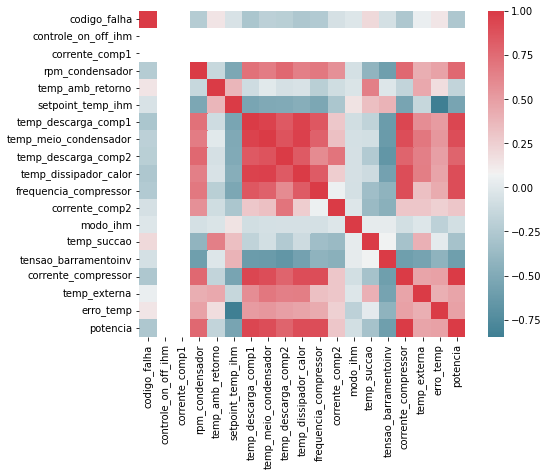

In [ ]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8, 6))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Parte de código para inserção de anomalias manualmente para testar retorno do método

In [ ]:
df.columns

Index(['time', 'codigo_falha', 'controle_on_off_ihm', 'corrente_comp1',
       'rpm_condensador', 'temp_amb_retorno', 'setpoint_temp_ihm',
       'temp_descarga_comp1', 'temp_meio_condensador', 'temp_descarga_comp2',
       'temp_dissipador_calor', 'frequencia_compressor', 'corrente_comp2',
       'modo_ihm', 'temp_succao', 'tensao_barramentoinv',
       'corrente_compressor', 'temp_externa', 'erro_temp', 'potencia', 'hora'],
      dtype='object')

In [ ]:
time = '2021-05-01 00:00:00.000000-03:00'
data_inverter = {'time': [time, time, time, time, time],
        'codigo_falha': [0,0,0,0,0],
        'controle_on_off_ihm': [1,1,1,1,1],
        'corrente_comp1': [0,0,0,0,0],
        'rpm_condensador': [0,0,0,0,0],
        'temp_amb_retorno': [22,22,22,22,22],
        'setpoint_temp_ihm': [85,22,22,22,22], #
        'temp_descarga_comp1': [22,22,22,22,22],
        'temp_meio_condensador': [22,22,22,22,22],
        'temp_descarga_comp2': [22,60,22,22,22], #
        'temp_dissipador_calor': [22,22,90,22,22], #
        'frequencia_compressor': [60,60,60,60,60], 
        'corrente_comp2': [0,0,0,0,0],
        'modo_ihm': [1,1,1,1,1],
        'temp_succao': [22,22,22,22,75], #
        'tensao_barramentoinv': [292,292,292,292,292],
        'corrente_compressor': [0,0,0,0,0],
        'temp_externa': [22,22,22,22,75], #
        'erro_temp': [0,0,0,0,0],
        'potencia': [0,0,0,0,0],
        'hora': '00'
        }

data_compressor3 = {'time': [time, time, time, time, time],
        'frequencia_compressor': [60,60,60,60,60],   
        'corrente_compressor': [0,0,0,0,0],          
        'codigo_falha': [0,0,0,0,0],
        'corrente_comp2': [0,0,0,0,0],
        'corrente_comp1': [0,0,0,0,0],
        'modo_ihm': [1,1,1,1,1],
        'setpoint_temp_ihm': [85,22,22,22,22], #
        'temp_succao': [22,22,22,22,75], #
        'temp_dissipador_calor': [22,22,90,22,22], #
        'temp_descarga_comp1': [22,22,22,22,22],
        'rpm_condensador': [0,0,0,0,0],
        'temp_meio_condensador': [22,22,22,22,22],
        'temp_descarga_comp2': [22,60,22,22,22], #
        'temp_amb_retorno': [22,22,22,22,22],
        'controle_on_off_ihm': [1,1,1,1,1],
        'erro_temp': [0,0,0,0,0],
        'potencia': [0,0,0,0,0],
        'hora': '00'
        }

if maquina_estudo == 'Inverter': data = data_inverter
if maquina_estudo == 'Compressor 1': data = data_compressor3 ######
if maquina_estudo == 'Compressor 3': data = data_compressor3

df_aux1 = pd.DataFrame(data=data)

df = df.append(df_aux1)
df = df.reset_index(drop=True) 

##X.2 Anomalias por Zscore e Zscore modificado

In [ ]:
workdir_path = '/content/drive/My Drive/2. Greenole/9. Análises/00. Trabalho BI Master/2. Estudo dos dados/Imagens Geradas/Análise HVAC-BK/' + maquina_estudo

df_stats_anomalies = pd.DataFrame()
df_stats_anomalies_aux = pd.DataFrame()
df_aux = df

if 'hora' in df_aux.columns: df_aux = df_aux.drop(columns=['hora'],axis=1)
if 'potencia' in df_aux.columns: df_aux = df_aux.drop(columns=['potencia'],axis=1)



threshold_pos = 4     # limite positivo para ser considerado anomalia
threshold_neg = -4    # limite negativo para ser considerado anomalia

#df_stats_anomalies_aux = estudo_estatistico_anomalias(workdir_path,df_aux,'potencia')

for variavel in df_aux.columns:
  df_stats_anomalies_aux = estudo_estatistico_anomalias(workdir_path, df_aux, variavel, threshold_pos, threshold_neg)
  if len(df_stats_anomalies_aux) > 0:
    df_stats_anomalies = df_stats_anomalies.append(df_stats_anomalies_aux, ignore_index=True)


# Parte que junta em um dataframe todas as anomalias

# Zscore ou mod_zscore acima do limite
df_stats_anomalies1 = df_stats_anomalies[df_stats_anomalies['zscore'] > threshold_pos]
df_stats_anomalies2 = df_stats_anomalies[df_stats_anomalies['mod_zscore'] > threshold_pos]

# Juntar dataframes
df_stats_anomalies = pd.DataFrame()
df_stats_anomalies = df_stats_anomalies.append(df_stats_anomalies1, ignore_index=True)
df_stats_anomalies = df_stats_anomalies.append(df_stats_anomalies2, ignore_index=True)

# Retirar infinitos
df_stats_anomalies = df_stats_anomalies[np.isfinite(df_stats_anomalies['zscore'])]
df_stats_anomalies = df_stats_anomalies[np.isfinite(df_stats_anomalies['mod_zscore'])]

# Retirar Zscore ou mod_zscore abaixo do limite
df_stats_anomalies = df_stats_anomalies.drop(df_stats_anomalies[df_stats_anomalies['zscore'] < threshold_pos].index)
df_stats_anomalies = df_stats_anomalies.drop(df_stats_anomalies[df_stats_anomalies['mod_zscore'] < threshold_pos].index)

# Excluindo duplicados
df_stats_anomalies = df_stats_anomalies.drop_duplicates(subset=['zscore'])

# Atualizando os indexes
df_stats_anomalies = df_stats_anomalies.reset_index(drop=True) 
#df_stats_anomalies = df_stats_anomalies.drop(columns=['index'],axis=1)

df_stats_anomalies.tail()

,time,valor,zscore,mod_zscore,variavel
0,2021-05-21 06:06:53.456000-03:00,42.75,10.475165,15.513287,corrente_compressor
1,2021-06-05 01:52:05.210000-03:00,30.00,5.908033,8.633482,corrente_compressor
2,2021-07-19 03:35:43.584000-03:00,56.00,15.221399,22.662890,corrente_compressor


In [ ]:
df_stats_anomalies

,time,valor,zscore,mod_zscore,variavel
0,2021-05-21 06:06:53.456000-03:00,42.75,10.475165,15.513287,corrente_compressor
1,2021-06-05 01:52:05.210000-03:00,30.00,5.908033,8.633482,corrente_compressor
2,2021-07-19 03:35:43.584000-03:00,56.00,15.221399,22.662890,corrente_compressor


In [ ]:
dados_anomalos_zs_time = df_stats_anomalies['time']
dados_anomalos_zs_time

0   2021-05-21 06:06:53.456000-03:00
1   2021-06-05 01:52:05.210000-03:00
2   2021-07-19 03:35:43.584000-03:00
Name: time, dtype: datetime64[ns, Etc/GMT+3]

In [ ]:
df_stats_anomalies.tail()

,time,valor,zscore,mod_zscore,variavel
0,2021-05-21 06:06:53.456000-03:00,42.75,10.475165,15.513287,corrente_compressor
1,2021-06-05 01:52:05.210000-03:00,30.00,5.908033,8.633482,corrente_compressor
2,2021-07-19 03:35:43.584000-03:00,56.00,15.221399,22.662890,corrente_compressor


In [ ]:
# Quantidade de anomalias por variável

df_qt_anomalies = pd.DataFrame()
df_qt_anomalies['qt'] = df_stats_anomalies['variavel'].value_counts()
df_qt_anomalies['variavel'] = df_qt_anomalies.index
df_qt_anomalies = df_qt_anomalies[['variavel','qt']]
df_qt_anomalies = df_qt_anomalies.reset_index() # atualizando os indexes
df_qt_anomalies = df_qt_anomalies.drop(columns=['index'],axis=1)
df_qt_anomalies

,variavel,qt
0,corrente_compressor,3


In [ ]:
df_stats_anomalies.head(25)

,time,valor,zscore,mod_zscore,variavel
0,2021-05-21 06:06:53.456000-03:00,42.75,10.475165,15.513287,corrente_compressor
1,2021-06-05 01:52:05.210000-03:00,30.00,5.908033,8.633482,corrente_compressor
2,2021-07-19 03:35:43.584000-03:00,56.00,15.221399,22.662890,corrente_compressor


##X.3 Anomalias por DBSCAN


In [ ]:
# Anomalias de potência por DBSCAN

def dbscan_anomalies(df):

  df_dbscan = df

  if 'time' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['time'],axis=1)
  if 'hora' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['hora'],axis=1)
  if 'codigo_falha' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['codigo_falha'],axis=1)
  if 'controle_on_off_ihm' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['controle_on_off_ihm'],axis=1)
  if 'modo_ihm' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['modo_ihm'],axis=1)
  if 'setpoint_temp_ihm' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['setpoint_temp_ihm'],axis=1)
  #if 'temp_externa' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['temp_externa'],axis=1)
  if 'erro_temp' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['erro_temp'],axis=1)
  if 'potencia' in df_dbscan.columns: df_dbscan = df_dbscan.drop(columns=['potencia'],axis=1)

  df_dbscan = df_dbscan.reset_index(drop=True) # atualizando os indexes


  X_normalized = sklearn.preprocessing.normalize(df_dbscan, norm='l2', axis=0)
  df_dbscan_norm = pd.DataFrame(X_normalized,columns=df_dbscan.columns)


  #__________________________________________________________
  # Aplicando o DBSCAN

  db = DBSCAN(eps=0.01, min_samples=10)
  db.fit(df_dbscan_norm)
  y_pred = db.fit_predict(df_dbscan_norm)
  df_dbscan_norm['dbscan_anomally'] = db.labels_

  df_dbscan['dbscan_anomally'] = db.labels_ ### usado como referência de anomalia no Isolation Forest



  for i in range(len(df_dbscan_norm['dbscan_anomally'])):
    if df_dbscan_norm['dbscan_anomally'][i] != -1:
      df_dbscan_norm['dbscan_anomally'][i] = 0
    else: df_dbscan_norm['dbscan_anomally'][i] = 1
    
    if df_dbscan['dbscan_anomally'][i] != -1:
      df_dbscan['dbscan_anomally'][i] = 0
    else: df_dbscan['dbscan_anomally'][i] = 1



  df_dbscan_norm['time'] = df['time']
  df_dbscan['time'] = df['time']


  
  return df_dbscan, df_dbscan_norm

In [ ]:
df_dbscan, df_dbscan_norm = dbscan_anomalies(df)

In [ ]:
anomalias_norm = df_dbscan_norm['dbscan_anomally'].index[df_dbscan_norm['dbscan_anomally'] == 1]
anomalias_norm = df_dbscan_norm.iloc[anomalias_norm.to_list()]
anomalias_norm

,corrente_comp1,rpm_condensador,temp_amb_retorno,temp_descarga_comp1,temp_meio_condensador,temp_descarga_comp2,temp_dissipador_calor,frequencia_compressor,corrente_comp2,temp_succao,tensao_barramentoinv,corrente_compressor,temp_externa,dbscan_anomally,time
31,0.0,0.028156,0.014968,0.012143,0.018241,0.016860,0.015584,0.024749,0.052806,0.005255,0.013514,0.021572,0.014408,1,2021-05-01 10:29:55.668000-03:00
139,0.0,0.028524,0.014968,0.006071,0.008419,0.007627,0.008500,0.000000,0.000000,0.014264,0.013894,0.027214,0.012350,1,2021-05-02 23:53:08.688000-03:00
1286,0.0,0.028340,0.013016,0.007286,0.008886,0.008430,0.009917,0.000000,0.000000,0.014264,0.013894,0.056752,0.011664,1,2021-05-21 06:06:53.456000-03:00
1445,0.0,0.025948,0.012365,0.017000,0.013564,0.020473,0.013459,0.000000,0.000000,0.011261,0.013894,0.000000,0.015094,1,2021-05-23 13:04:22.750000-03:00
1946,0.0,0.028340,0.013666,0.009714,0.011225,0.011642,0.011688,0.000000,0.000000,0.015766,0.013894,0.056752,0.015781,1,2021-05-31 15:24:11.706000-03:00
2231,0.0,0.028156,0.014968,0.006982,0.009822,0.008832,0.009563,0.005569,0.000000,0.016517,0.013894,0.039826,0.013722,1,2021-06-05 01:52:05.210000-03:00
4829,0.0,0.028156,0.013016,0.006375,0.007016,0.006824,0.006021,0.000000,0.000000,0.011261,0.014465,0.074341,0.008233,1,2021-07-19 03:35:43.584000-03:00


In [ ]:
df_dbscan['dbscan_anomally'].value_counts()

0    5289
1       7
Name: dbscan_anomally, dtype: int64

In [ ]:
anomalias = df.iloc[anomalias_norm.index]
anomalias['time']

31     2021-05-01 10:29:55.668000-03:00
139    2021-05-02 23:53:08.688000-03:00
1286   2021-05-21 06:06:53.456000-03:00
1445   2021-05-23 13:04:22.750000-03:00
1946   2021-05-31 15:24:11.706000-03:00
2231   2021-06-05 01:52:05.210000-03:00
4829   2021-07-19 03:35:43.584000-03:00
Name: time, dtype: datetime64[ns, Etc/GMT+3]

In [ ]:

#plt.figure(figsize=(8,5))
#plt.scatter(df_dbscan_norm['temp_descarga_comp2'], df_dbscan_norm['temp_dissipador_calor'],c=y_pred, cmap='Paired')
#plt.scatter(df_dbscan_norm['corrente_compressor'], df_dbscan_norm['temp_descarga_comp1'],c=y_pred, cmap='Paired')
#plt.title("Clusters determined by DBSCAN")

##X.4 Geração de dados sintéticos para treinamento supervisionado

In [ ]:
from random import seed
from random import random, uniform

In [ ]:
df_dbscan.columns

Index(['corrente_comp1', 'rpm_condensador', 'temp_amb_retorno',
       'temp_descarga_comp1', 'temp_meio_condensador', 'temp_descarga_comp2',
       'temp_dissipador_calor', 'frequencia_compressor', 'corrente_comp2',
       'temp_succao', 'tensao_barramentoinv', 'corrente_compressor',
       'temp_externa', 'dbscan_anomally', 'time'],
      dtype='object')

In [ ]:
df.tail()

,time,codigo_falha,controle_on_off_ihm,corrente_comp1,rpm_condensador,temp_amb_retorno,setpoint_temp_ihm,temp_descarga_comp1,temp_meio_condensador,temp_descarga_comp2,temp_dissipador_calor,frequencia_compressor,corrente_comp2,modo_ihm,temp_succao,tensao_barramentoinv,corrente_compressor,temp_externa,erro_temp,potencia,hora
5291,2021-07-29 20:40:44.181000-03:00,0,1.0,0.0,0.0,17.0,30.0,9.0,8.0,9.0,13.0,0.0,0.0,-1.0,9.0,292.0,0.0,8.0,-13.0,0.0,20
5292,2021-07-29 20:55:44.164000-03:00,0,1.0,0.0,0.0,17.0,30.0,9.0,8.0,9.0,13.0,0.0,0.0,-1.0,9.0,292.0,0.0,8.0,-13.0,0.0,20
5293,2021-07-29 21:10:44.161000-03:00,0,1.0,0.0,0.0,17.0,30.0,8.0,8.0,9.0,13.0,0.0,0.0,-1.0,9.0,292.0,0.0,8.0,-13.0,0.0,21
5294,2021-07-29 21:40:44.181000-03:00,0,1.0,0.0,0.0,17.0,30.0,8.0,8.0,9.0,13.0,0.0,0.0,-1.0,8.0,292.0,0.0,8.0,-13.0,0.0,21
5295,2021-07-29 22:10:44.198000-03:00,0,1.0,0.0,0.0,16.0,30.0,8.0,8.0,9.0,13.0,0.0,0.0,0.0,8.0,292.0,0.0,7.0,-14.0,0.0,22


In [ ]:
seed(1)

df_dbscan_resampled = df_dbscan # dataframe com dados já rotulados


corrente_comp1 = 0
rpm_condensador_array = [400, 1200]
temp_amb_retorno = 22
setpoint_temp_ihm = 22
temp_descarga_comp1_array = [60,120]
temp_meio_condensador_array = [30,100]
temp_descarga_comp2_array = [70,120]
temp_dissipador_calor_array = [40,120]
frequencia_compressor_array = [60,120]
corrente_comp2_array = [20,50]
temp_succao_array = [20,60]
tensao_barramentoinv_array = [290,400]
corrente_compressor_array = [18,45]
temp_externa = 25
time = '2021-05-01 00:00:00.000000-03:00'


for i in range(0,4001):

  if str(i)[-1] == '0':
    rpm_condensador = rpm_condensador_array[1] * uniform(0.8,1.2)
  else: 
    rpm_condensador = rpm_condensador_array[0]
  if str(i)[-1] == '1': 
    temp_descarga_comp1 = temp_descarga_comp1_array[1] * uniform(0.8,1.2) 
  else: 
    temp_descarga_comp1 = temp_descarga_comp1_array[0]
  if str(i)[-1] == '2': 
    temp_meio_condensador = temp_meio_condensador_array[1] * uniform(0.8,1.2) 
  else: 
      temp_meio_condensador = temp_meio_condensador_array[0]
  if str(i)[-1] == '3': 
    temp_descarga_comp2 = temp_descarga_comp2_array[1] * uniform(0.8,1.2) 
  else: 
      temp_descarga_comp2 = temp_descarga_comp2_array[0]
  if str(i)[-1] == '4': 
    temp_dissipador_calor = temp_dissipador_calor_array[1] * uniform(0.8,1.2) 
  else: 
      temp_dissipador_calor = temp_dissipador_calor_array[0]
  if str(i)[-1] == '5': 
    frequencia_compressor = frequencia_compressor_array[1] * uniform(0.8,1.2) 
  else: 
      frequencia_compressor = frequencia_compressor_array[0]
  if str(i)[-1] == '6': 
    corrente_comp2 = corrente_comp2_array[1] * uniform(0.8,1.2) 
  else: 
      corrente_comp2 = corrente_comp2_array[0]
  if str(i)[-1] == '7': 
    temp_succao = temp_succao_array[1] * uniform(0.8,1.2) 
  else: 
      temp_succao = temp_succao_array[0]
  if str(i)[-1] == '8': 
    tensao_barramentoinv = tensao_barramentoinv_array[1] * uniform(0.8,1.2) 
  else: 
      tensao_barramentoinv = tensao_barramentoinv_array[0]
  if str(i)[-1] == '9': 
    corrente_compressor = corrente_compressor_array[1] * uniform(0.8,1.2) 
  else: 
      corrente_compressor = corrente_compressor_array[0]

  data_inverter = {
        'corrente_comp1': corrente_comp1,
        'rpm_condensador': rpm_condensador,
        'temp_amb_retorno': temp_amb_retorno,
        'temp_descarga_comp1': temp_descarga_comp1,
        'temp_meio_condensador': temp_meio_condensador,
        'temp_descarga_comp2': temp_descarga_comp2,
        'temp_dissipador_calor': temp_dissipador_calor,
        'frequencia_compressor': frequencia_compressor, 
        'corrente_comp2': corrente_comp2,
        'temp_succao': temp_succao,
        'tensao_barramentoinv': tensao_barramentoinv,
        'corrente_compressor': corrente_compressor,
        'temp_externa': temp_externa,
        'dbscan_anomally': 1,
        'time': time,
  }
  
  #print(data_inverter)

  df_aux2 = pd.DataFrame(data=data_inverter, index=[0])

  df_dbscan_resampled = df_dbscan_resampled.append(df_aux2)


df_dbscan_resampled = df_dbscan_resampled.reset_index(drop=True) 

In [ ]:
df_dbscan_resampled['dbscan_anomally'].value_counts()

0    5289
1    4008
Name: dbscan_anomally, dtype: int64

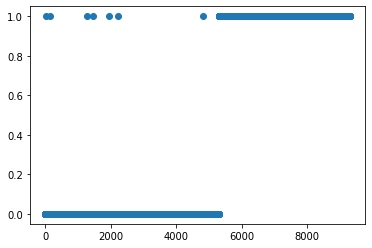

In [ ]:
plt.scatter(df_dbscan_resampled.index,df_dbscan_resampled['dbscan_anomally'])

##X.4 Anomalias por KNN

In [ ]:
# Divisão da base entre treino e teste

from sklearn.model_selection import train_test_split

df_aux_knn = df_dbscan_resampled

columns = df_aux_knn.columns.tolist()
columns = [c for c in columns if c not in ['codigo_falha','time','hora','erro_temp','dbscan_anomally']]
target = 'dbscan_anomally'


X = df_aux_knn[columns]
y = df_aux_knn[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
# KNN - K Nearst Neighbors
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)

y_pred = neigh.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred)

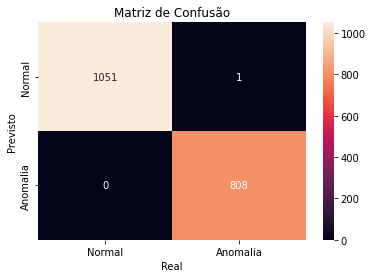

In [ ]:
# Matriz de confusão
import seaborn as sns
from sklearn.metrics import confusion_matrix
confMatrix = confusion_matrix(y_pred, y_test)

ax = plt.subplot()
sns.heatmap(confMatrix, annot=True, fmt=".0f")
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Matriz de Confusão')

# Colocar os nomes
ax.xaxis.set_ticklabels(['Normal', 'Anomalia']) 
ax.yaxis.set_ticklabels(['Normal', 'Anomalia'])
plt.show()

##X.4 Anomalias por Isolation Forest

In [ ]:
# Misturar registros
seed(1)

size = len(df_dbscan_resampled['time'])
df_dbscan_resampled['shuffle'] = np.random.random_sample((size,))

In [ ]:
df_dbscan_resampled = df_dbscan_resampled.sort_values(by=['shuffle'])
df_dbscan_resampled.head()

,corrente_comp1,rpm_condensador,temp_amb_retorno,temp_descarga_comp1,temp_meio_condensador,temp_descarga_comp2,temp_dissipador_calor,frequencia_compressor,corrente_comp2,temp_succao,tensao_barramentoinv,corrente_compressor,temp_externa,dbscan_anomally,time,shuffle
1185,0.0,612.0,21.0,30.000000,18.0,18.0,26.0,30.0,0.0,18.0,284.0,5.5,16.0,0,2021-05-20 00:44:08.694000-03:00,1.566658e-07
2791,0.0,252.0,22.0,60.000000,36.0,39.0,49.0,60.0,0.0,19.0,284.0,14.0,21.0,0,2021-06-16 14:51:27.389000-03:00,1.528207e-05
4006,0.0,48.0,21.0,24.000000,21.0,22.0,30.0,0.0,0.0,21.0,292.0,0.0,20.0,0,2021-07-06 10:47:49.356000-03:00,1.150376e-04
8227,0.0,400.0,22.0,115.106441,30.0,70.0,40.0,60.0,20.0,20.0,290.0,18.0,25.0,1,2021-05-01 00:00:00.000000-03:00,1.368358e-04
3793,0.0,0.0,20.0,20.000000,16.0,19.0,26.0,0.0,0.0,17.0,292.0,0.0,15.0,0,2021-07-04 01:47:36.933000-03:00,1.618815e-04


In [ ]:
df_dbscan_resampled['dbscan_anomally'].value_counts()

0    5289
1    4008
Name: dbscan_anomally, dtype: int64

In [ ]:
df_dbscan_resampled.columns

Index(['corrente_comp1', 'rpm_condensador', 'temp_amb_retorno',
       'temp_descarga_comp1', 'temp_meio_condensador', 'temp_descarga_comp2',
       'temp_dissipador_calor', 'frequencia_compressor', 'corrente_comp2',
       'temp_succao', 'tensao_barramentoinv', 'corrente_compressor',
       'temp_externa', 'dbscan_anomally', 'time', 'shuffle'],
      dtype='object')

In [ ]:
state = np.random.RandomState(42)

df_aux_if = df_dbscan_resampled

columns = df_aux_if.columns.tolist()
columns = [c for c in columns if c not in ['codigo_falha','time','hora','erro_temp','dbscan_anomally','shuffle']]

target = 'dbscan_anomally'

X = df_aux_if[columns]
Y = df_aux_if[target]

falha = df_aux[df_aux_if['dbscan_anomally'] != 0]
normal = df_aux[df_aux_if['dbscan_anomally'] == 0]
outlier_fraction = len(falha)/float(len(normal))

clf = IsolationForest(n_estimators= 100, max_samples=len(df_aux_if),contamination=outlier_fraction,random_state=state, verbose=0)
clf.fit(X)
scores_prediction = clf.decision_function(X)
y_pred = clf.predict(X)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()


# Run Classification Metrics
print("{}: {}".format('Isolation Forest',n_errors))
print("Accuracy Score :")
print(accuracy_score(Y,y_pred))
print("Classification Report :")
print(classification_report(Y,y_pred))

Isolation Forest: 4017
Accuracy Score :
0.5679251371410132
Classification Report :
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      5289
           1       0.15      0.00      0.00      4008

    accuracy                           0.57      9297
   macro avg       0.36      0.50      0.36      9297
weighted avg       0.39      0.57      0.41      9297



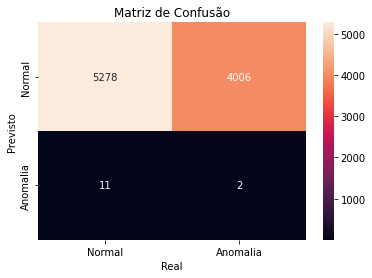

In [ ]:
# Matriz de confusão
import seaborn as sns
from sklearn.metrics import confusion_matrix
confMatrix = confusion_matrix(y_pred, Y)

ax = plt.subplot()
sns.heatmap(confMatrix, annot=True, fmt=".0f")
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Matriz de Confusão')

# Colocar os nomes
ax.xaxis.set_ticklabels(['Normal', 'Anomalia']) 
ax.yaxis.set_ticklabels(['Normal', 'Anomalia'])
plt.show()

##X.y Gerando relatório em WORD

In [ ]:
# _______________________________________________________________
# Função para impressão de dataframe em documento

def print_dataframe (df, document):
  # add a table to the end and create a reference variable
  # extra row is so we can add the header row
  t = document.add_table(df.shape[0]+1, df.shape[1])

  # add the header rows.
  for j in range(df.shape[-1]):
      t.cell(0,j).text = df.columns[j]

  # add the rest of the data frame
  for i in range(df.shape[0]):
      for j in range(df.shape[-1]):
          t.cell(i+1,j).text = str(df.values[i,j])

# _______________________________________________________________

In [ ]:
workdir_path = '/content/drive/My Drive/2. Greenole/9. Análises/00. Trabalho BI Master/2. Estudo dos dados/Imagens Geradas/Análise HVAC-BK/' + maquina_estudo
os.chdir(workdir_path)

variaveis_estudo = df.columns.drop(['time','hora'])
#['codigo_falha', 'controle_on_off_ihm', 'corrente_comp1','rpm_condensador', 'temp_amb_retorno', 'setpoint_temp_ihm',
       #'temp_descarga_comp1', 'temp_meio_condensador', 'temp_descarga_comp2','temp_dissipador_calor', 'frequencia_compressor', 'corrente_comp2',
       #'modo_ihm', 'temp_succao', 'tensao_barramentoinv','corrente_compressor', 'temp_externa', 'erro_temp', 'potencia']

document = Document()

document.add_heading('Análise ' + maquina_estudo + ' BK', 0)

p = document.add_paragraph('Análise de dados da máquina ' + maquina_estudo + ' no período de ' + data_inicial + ' a ' + data_final + '.')
p = document.add_paragraph(' ')
document.add_heading('Configurações para estudo', level=1)
p = document.add_paragraph(' ')
p = document.add_paragraph('Data inicial: '+data_inicial)
p = document.add_paragraph('Data final: '+data_final)
p = document.add_paragraph('Hora de início: '+str(hora_inicial))
p = document.add_paragraph('Hora final:'+str(hora_final))
if func_maq == 0:
  func_maq_desc = 'Não'
else:
    func_maq_desc = 'Sim'
p = document.add_paragraph('Restrição de máquina ligada? '+func_maq_desc)
p = document.add_paragraph('Tolerância ao redor do setpoint: +-'+str(tol_temp_sp)+'°C')
p = document.add_paragraph('Temperatura limite superior: '+str(lim_temp_sup)+'°C')
p = document.add_paragraph('Temperatura limite inferior: '+str(lim_temp_inf)+'°C')
p = document.add_paragraph(' ')

document.add_heading('Tabela Resumo do período', level=1)
p = document.add_paragraph(' ')

lista_index = df_geral.index.to_list()
lista_valores = df_geral[df_geral.columns[0]].to_list()


table = document.add_table(rows=1, cols=2)
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'INFO'
hdr_cells[1].text = 'VALOR'
for i in range(len(df_geral)-1):
  row_cells = table.add_row().cells
  row_cells[0].text = str(lista_index[i])
  row_cells[1].text = str(lista_valores[i])

document.add_page_break()

p = document.add_paragraph(' ')

document.add_heading('Gráficos de variáveis', level=1)
p = document.add_paragraph(' ')

for i in range(len(variaveis_estudo)):
  p = document.add_paragraph()
  document.add_heading(variaveis_estudo[i], level=2)
  document.add_picture(variaveis_estudo[i] + '_scatter', width=Inches(4))
  document.add_picture(variaveis_estudo[i] + '_hist', width=Inches(4))


p = document.add_paragraph(' ')

document.add_heading('Anomalias', level=1)
p = document.add_paragraph(' ')

# Print do dataframe de anomalias por variavel
print_dataframe(df_qt_anomalies, document)
p = document.add_paragraph(' ')

document.add_heading('Métodos Estatísticos', level=2)
p = document.add_paragraph(' ')

# Print do dataframe de anomalias
print_dataframe(df_stats_anomalies, document)
p = document.add_paragraph(' ')

workdir_path = '/content/drive/My Drive/2. Greenole/9. Análises/00. Trabalho BI Master/2. Estudo dos dados'
os.chdir(workdir_path)
document.save('BK_' + maquina_estudo + '.docx')